# Classificação de comentários tóxicos

<blockquote><b>Isenção de responsabilidade:</b> o conjunto de dados contém texto que pode ser considerado profano, vulgar ou ofensivo.</blockquote>

### Bibliotecas básicas

In [1]:
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

### Bibiotecas de visualização

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Bibliotecas de aprendizado de máquina

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

### Carregamento dos dados

In [4]:
df = pd.read_csv('datasets/train.csv', encoding = 'ISO-8859-1')
df.drop(['id'], axis=1, inplace=True)
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')

Linhas: 159571 | Colunas: 7


In [5]:
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0


### Dicionário dos dados

<ul>
    <li><b>comment_text</b>: comentário</li>
    <li><b>toxic</b>: tóxico</li>
    <li><b>severe_toxic</b>: severamente tóxico</li>
    <li><b>obscene</b>: obsceno</li>
    <li><b>threat</b>: ameaça</li>
    <li><b>insult</b>: insulto</li>
    <li><b>identity_hate</b>: ódio de identidade</li>    
</ul>

### Informações dos dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


### Descrição dos dados

In [7]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Comentários por categoria

In [8]:
counts = []
categories = list(df.iloc[:, 1:].columns.values)

for i in categories:
    counts.append((i, df[i].sum()))

df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


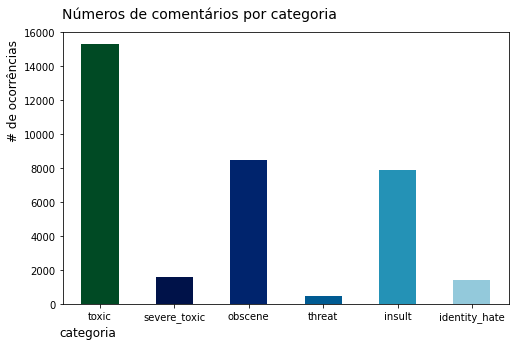

In [22]:
df_stats.plot(x='category', 
              y='number_of_comments', 
              kind='bar', 
              legend=False, 
              grid=False, 
              figsize=(8, 5), 
              rot=0, color=sns.color_palette('ocean', n_colors=6))

plt.title('Números de comentários por categoria', y=1.03, size=14, loc='left', x=-0.001)
plt.ylabel('# de ocorrências', fontsize=12, horizontalalignment='left', y=0.60)
plt.xlabel('categoria', fontsize=12, horizontalalignment='right', x=0.12)
plt.ylim(0, 16000)
plt.show()

### Multilabel

<p align='justify'>Quantos comentários têm vários rótulos?</p>

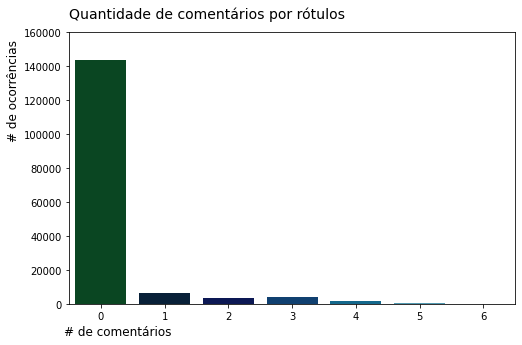

In [23]:
rowsums = df.iloc[:, 1:].sum(axis=1)
x=rowsums.value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x.index, x.values, palette=sns.color_palette('ocean', n_colors=7))
plt.title('Quantidade de comentários por rótulos', y=1.03, size=14, loc='left', x=-0.001)
plt.ylabel('# de ocorrências', fontsize=12, horizontalalignment='left', y=0.60)
plt.xlabel('# de comentários', fontsize=12, horizontalalignment='right', x=0.23)
plt.ylim(0, 160000)
plt.show()

<p align='justify'>Uma grande maioria dos comentários não está rotulada.</p>

In [11]:
print('Porcentagem de comentários que não estão rotulados:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Porcentagem de comentários que não estão rotulados:
0.8983211235124177


<p align='justify'>Distribuição do número de palavras em textos de comentários </p>

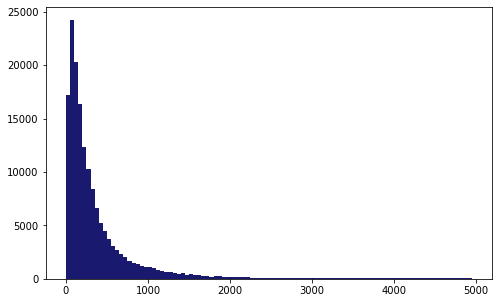

In [12]:
plt.figure(figsize=[8, 5])
df['comment_text'].str.len().hist(bins=np.arange(0, 5000, 50), grid=False, color=['#191970'])
plt.show()

<p align='justify'>A maior parte dos comentários possuem até 500 carecteres, com alguns valores discrepantes de até 5000 caracteres.</p>

### Valores faltantes

In [13]:
print('# de comentários faltantes: ', df['comment_text'].isnull().sum())

# de comentários faltantes:  0


### Pré-processamento dos dados

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

<p align='justify'>Testando a função de limpeza.</p>

In [15]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [16]:
clean_text(df['comment_text'][0])

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

#### Limpando a coluna de comentários

In [17]:
df['comment_text'] = df['comment_text'].apply(clean_text)

### Divisão dos dados

In [18]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (106912,)
X_test: (52659,)


### Modelagem

#### Naive Bayes

In [19]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
])

for category in categories:
    print('... Processando {}'.format(category))
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print('Acurácia do teste {}'.format(accuracy_score(test[category], prediction)))

... Processando toxic
Acurácia do teste 0.9192350785240889
... Processando severe_toxic
Acurácia do teste 0.9900112041626312
... Processando obscene
Acurácia do teste 0.9515752293055318
... Processando threat
Acurácia do teste 0.9971135038644866
... Processando insult
Acurácia do teste 0.9517271501547694
... Processando identity_hate
Acurácia do teste 0.9910556600011394


#### LinearSVC

In [20]:
SVC_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
])

for category in categories:
    print('... Processando {}'.format(category))
    SVC_pipeline.fit(X_train, train[category])
    prediction = SVC_pipeline.predict(X_test)
    print('Acurácia do teste {}'.format(accuracy_score(test[category], prediction)))

... Processando toxic
Acurácia do teste 0.9600068364382157
... Processando severe_toxic
Acurácia do teste 0.9906948479842003
... Processando obscene
Acurácia do teste 0.9788830019559809
... Processando threat
Acurácia do teste 0.9974363356691164
... Processando insult
Acurácia do teste 0.971135038644866
... Processando identity_hate
Acurácia do teste 0.9919861752027194


#### Regressão Logística

In [21]:
LogReg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))
])

for category in categories:
    print('... Processando {}'.format(category))
    LogReg_pipeline.fit(X_train, train[category])
    prediction = LogReg_pipeline.predict(X_test)
    print('Acurácia do teste {}'.format(accuracy_score(test[category], prediction)))

... Processando toxic
Acurácia do teste 0.9548415275641391
... Processando severe_toxic
Acurácia do teste 0.9910746501072941
... Processando obscene
Acurácia do teste 0.9760724662450863
... Processando threat
Acurácia do teste 0.9973793653506523
... Processando insult
Acurácia do teste 0.9687422852693747
... Processando identity_hate
Acurácia do teste 0.991758293928863
